# Contents

----

----

__This notebook investigates the dataset derived from `Ming et al.` (race-cancer correlation 0.025). Inductive Conformal Predictors are applied to underlying classifiers: `ADA`, `RF`, `LR`, and `KNN`.__

$H_0$ = There is no difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

$H_a$ = There is a difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

----

In [1]:
import os

# set pwd to root of repository
repo_root = 'C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/'
#repo_root = '/uufs/chpc.utah.edu/common/home/u0740821/conformal_prediction/vigilant-computing-machine'

os.chdir(repo_root)

In [2]:
# 'vigilant-computing-machine/source/util.py'
import source.util as util

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import Orange
from Orange.distance import Euclidean
import orangecontrib.conformal as cp

# Read in Data

In [3]:
normalizer = Orange.preprocess.Normalizer(norm_type = Orange.preprocess.Normalize.NormalizeBySD)
tab_signal = normalizer(Orange.data.Table('./data/signal_with_header_for_orange.csv'))

----
## Get `Race` distribution and cancer occurrence in population sample

In [4]:
tab_signal.domain

[T1, N_Biop, HypPlas, AgeMen, Age1st, N_Rels, Race | Case_signalYN]

In [5]:
# get distribution of race
df_race_signal = pd.DataFrame()
df_race_signal['race'] = tab_signal.X[:,-1].astype(int)
df_race_signal_counts = df_race_signal.value_counts().sort_index()
n_signal_race = df_race_signal_counts.values.sum()

# get occurrence of cancer by race
df_race_signal['cancer'] = tab_signal.Y.astype(int)
p_cancer_by_race = df_race_signal.groupby('race').mean('cancer')

df_race_signal_prop = pd.DataFrame({'count_n': df_race_signal_counts,
                                    'count_p': df_race_signal_counts / n_signal_race,                                    
                                    'cancer': p_cancer_by_race.values.flatten()})
df_race_signal_prop

,count_n,count_p,cancer
race,,,
0,589,0.490833,0.490662
1,234,0.195000,0.478632
2,260,0.216667,0.526923
3,94,0.078333,0.510638
4,17,0.014167,0.647059
5,4,0.003333,0.500000
6,2,0.001667,0.000000


## Get Cancer (`Case_signalYN`) Correlation with Independent Variables

In [44]:
df_tab_signal = util.table_to_df(tab_signal, x_only=False)
df_cancer_X_correlation_matrix = pd.DataFrame(df_tab_signal.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


----

----

----

# Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.986101,0.497341,0.935,0.0,1.0,0.935,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...


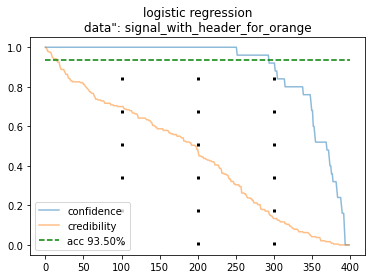

In [8]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.classification.LogisticRegressionLearner()))

experiment_logistic = util.run_experiments(cc, train, test, calibrate, times=1)

util.plot_experiments(experiment_logistic)
experiment_logistic

In [10]:
df_pred_logistic = experiment_logistic.loc[0, 'df']
df_pred_logistic = util.sort_reindex(df_pred_logistic, col=['confidence','credibility'])
df_pred_logistic.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
0,[0],0.996269,0.996269,0.1,"[(0.996268656716418, 0), (0.003731343283582089...",True,-2.903715,0,2,0.51721,-0.543679,0,0,0
1,[1],0.996269,0.992537,0.1,"[(0.0037313432835820895, 0), (0.99253731343283...",True,2.674286,0,2,0.51721,-0.440318,0,2,1
2,[1],0.996269,0.988806,0.1,"[(0.0037313432835820895, 0), (0.98880597014925...",True,2.674286,0,2,0.51721,2.040345,0,0,1


---
## Get Lower Decile Range (LDR) - lowest 10th percentile `confidence`/`credibility`

In [12]:
ldr_idx = int(len(df_pred_logistic.index.values) / 10)
df_pred_logistic_ldr = df_pred_logistic.iloc[-ldr_idx:,:]
df_pred_logistic_ldr.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,[0],0.951493,0.134328,0.1,"[(0.13432835820895522, 0), (0.0485074626865671...",True,-0.114714,0,2,1.475007,2.040345,1,0,0
361,[1],0.951493,0.130597,0.1,"[(0.048507462686567165, 0), (0.130597014925373...",False,-0.114714,1,1,0.517210,-0.509225,0,0,0
362,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",False,0.084500,0,2,-1.398384,-0.509225,0,0,1


In [13]:
df_pred_logistic_ldr.tail(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
397,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",False,-0.114714,0,2,0.51721,-0.543679,3,2,1
398,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",True,0.084500,0,2,0.51721,-0.543679,0,0,0
399,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",True,0.084500,0,2,0.51721,-0.543679,0,0,0


----
### Get `Race` distribution in 10% lowest confidence region

In [40]:
logistic_ldr_race_counts = df_pred_logistic_ldr.Race.value_counts().sort_index()
n_logistic_ldr_race = logistic_ldr_race_counts.values.sum()
logistic_ldr_race_prop = pd.DataFrame({'low_confidence_p': logistic_ldr_race_counts / n_logistic_ldr_race, 
                                       'low_confidence_n': logistic_ldr_race_counts})
df_logistic_ldr_race_disparity = df_race_signal_prop.join(logistic_ldr_race_prop, on='race', how='left')
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.fillna(0)
df_logistic_ldr_race_disparity['low_confidence_n'] = df_logistic_ldr_race_disparity['low_confidence_n'].astype(int)
df_logistic_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.550,22
1,0.195000,234,0.200,8
2,0.216667,260,0.175,7
3,0.078333,94,0.075,3
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


# Random Forest
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.965476,0.627994,0.93,0.0,0.9725,0.9025,0.0275,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...


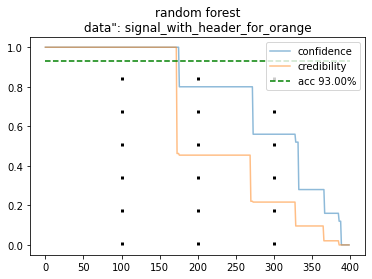

In [64]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.classification.RandomForestLearner()))

experiment_rf = util.run_experiments(cc, train, test, calibrate, times=1)

util.plot_experiments(experiment_rf)
experiment_rf

---
## Get Lower Decile Range (LDR) - lowest 10th percentile `confidence`/`credibility`

In [66]:
df_pred_rf = experiment_rf.loc[0, 'df']
df_pred_rf = util.sort_reindex(df_pred_rf, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_rf.index.values) / 10)
df_pred_rf_ldr = df_pred_rf.iloc[-ldr_idx:,:]
df_pred_rf_ldr.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,[1],0.921642,0.190299,0.1,"[(0.07835820895522388, 0), (0.1902985074626865...",True,0.084500,1,0,-0.440587,-0.509225,0,0,1
361,[0],0.921642,0.190299,0.1,"[(0.19029850746268656, 0), (0.0783582089552238...",True,0.084500,0,2,0.517210,-0.543679,0,0,0
362,[1],0.921642,0.190299,0.1,"[(0.07835820895522388, 0), (0.1902985074626865...",False,-0.313929,1,0,0.517210,2.040345,2,0,0


In [67]:
df_pred_rf_ldr.tail(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
397,"[0, 1]",0.895522,0.104478,0.1,"[(0.1044776119402985, 0), (0.1044776119402985,...",True,-0.114714,0,2,0.517210,-0.509225,0,2,0
398,"[0, 1]",0.895522,0.104478,0.1,"[(0.1044776119402985, 0), (0.1044776119402985,...",True,0.682143,0,2,-2.356181,2.040345,0,0,1
399,"[0, 1]",0.895522,0.104478,0.1,"[(0.1044776119402985, 0), (0.1044776119402985,...",True,0.084500,0,2,0.517210,-0.509225,2,0,1


----
### Get `Race` distribution in 10% lowest confidence region

In [71]:
rf_ldr_race_counts = df_pred_rf_ldr.Race.value_counts().sort_index()
n_rf_ldr_race = rf_ldr_race_counts.values.sum()
rf_ldr_race_prop = pd.DataFrame({'low_confidence_p': rf_ldr_race_counts / n_rf_ldr_race, 
                                 'low_confidence_n': rf_ldr_race_counts})
df_rf_ldr_race_disparity = df_race_signal_prop.join(rf_ldr_race_prop, on='race', how='left')
df_rf_ldr_race_disparity = df_rf_ldr_race_disparity.fillna(0)
df_rf_ldr_race_disparity['low_confidence_n'] = df_rf_ldr_race_disparity['low_confidence_n'].astype(int)
df_rf_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.675,27
1,0.195000,234,0.150,6
2,0.216667,260,0.075,3
3,0.078333,94,0.075,3
4,0.014167,17,0.025,1
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


----

# ADA
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.983619,0.503125,0.9,0.035,0.965,0.9,0.0,signal_with_header_for_orange,False,ada boost classification,InductiveClassifier (InverseProbability (ada b...,InverseProbability (ada boost classification),,SklAdaBoostClassifier(skl_model=AdaBoostClassi...,InductiveClassifier (InverseProbability (ada b...,classes confidence credibility eps \ 0...


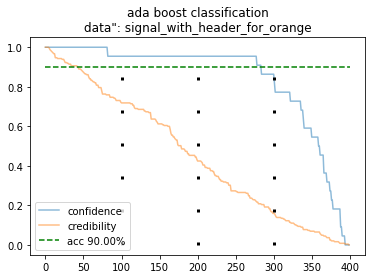

In [72]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.modelling.ada_boost.SklAdaBoostClassificationLearner()))

experiment_ada = util.run_experiments(cc, train, test, calibrate, times=1)

util.plot_experiments(experiment_ada)
experiment_ada

---
## Get Lower Decile Range (LDR) - lowest 10th percentile `confidence`/`credibility`

In [73]:
df_pred_ada = experiment_ada.loc[0, 'df']
df_pred_ada = util.sort_reindex(df_pred_ada, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_ada.index.values) / 10)
df_pred_ada_ldr = df_pred_ada.iloc[-ldr_idx:,:]
df_pred_ada_ldr.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,[1],0.955224,0.145522,0.1,"[(0.04477611940298507, 0), (0.1455223880597015...",True,0.084500,0,2,1.475007,-0.336957,0,3,1
361,[1],0.951493,0.138060,0.1,"[(0.048507462686567165, 0), (0.138059701492537...",True,0.283714,0,2,1.475007,2.040345,0,1,1
362,[0],0.951493,0.134328,0.1,"[(0.13432835820895522, 0), (0.0485074626865671...",False,0.084500,0,2,-1.398384,-0.440318,0,0,1


In [74]:
df_pred_ada_ldr.tail(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
397,[],0.914179,0.089552,0.1,"[(0.08955223880597014, 0), (0.0858208955223880...",False,0.084500,0,2,-0.440587,-0.509225,0,0,0
398,[],0.914179,0.089552,0.1,"[(0.08582089552238806, 0), (0.0895522388059701...",False,-0.313929,1,0,0.517210,2.040345,2,0,0
399,[],0.914179,0.085821,0.1,"[(0.08582089552238806, 0), (0.0858208955223880...",False,-0.313929,1,0,-0.440587,-0.440318,0,0,0


----
### Get `Race` distribution in 10% lowest confidence region

In [75]:
ada_ldr_race_counts = df_pred_ada_ldr.Race.value_counts().sort_index()
n_ada_ldr_race = ada_ldr_race_counts.values.sum()
ada_ldr_race_prop = pd.DataFrame({'low_confidence_p': ada_ldr_race_counts / n_ada_ldr_race, 
                                 'low_confidence_n': ada_ldr_race_counts})
df_ada_ldr_race_disparity = df_race_signal_prop.join(ada_ldr_race_prop, on='race', how='left')
df_ada_ldr_race_disparity = df_ada_ldr_race_disparity.fillna(0)
df_ada_ldr_race_disparity['low_confidence_n'] = df_ada_ldr_race_disparity['low_confidence_n'].astype(int)
df_ada_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.625,25
1,0.195000,234,0.200,8
2,0.216667,260,0.125,5
3,0.078333,94,0.050,2
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


----

# KNN
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.946259,0.690326,0.9575,0.0,0.77,0.7275,0.23,signal_with_header_for_orange,False,knn,InductiveClassifier (InverseProbability (knn)),InverseProbability (knn),,SklModelClassification(skl_model=KNeighborsCla...,InductiveClassifier (InverseProbability (knn)),classes confidence credibility eps \ 0...


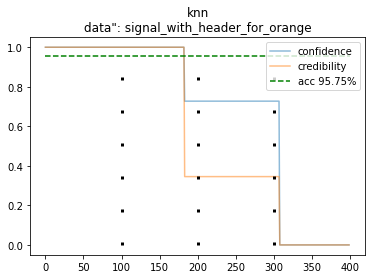

In [76]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.classification.knn.KNNLearner()))

experiment_knn = util.run_experiments(cc, train, test, calibrate, times=1)

util.plot_experiments(experiment_knn)
experiment_knn

---
## Get Lower Decile Range (LDR) - lowest 10th percentile `confidence`/`credibility`

In [77]:
df_pred_knn = experiment_knn.loc[0, 'df']
df_pred_knn = util.sort_reindex(df_pred_knn, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_knn.index.values) / 10)
df_pred_knn_ldr = df_pred_knn.iloc[-ldr_idx:,:]
df_pred_knn_ldr.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,"[0, 1]",0.86194,0.287313,0.1,"[(0.2873134328358209, 0), (0.13805970149253732...",True,-0.712357,6,0,-0.440587,-0.509225,0,2,1
361,"[0, 1]",0.86194,0.287313,0.1,"[(0.2873134328358209, 0), (0.13805970149253732...",True,0.283714,0,2,-0.440587,2.040345,0,0,1
362,"[0, 1]",0.86194,0.287313,0.1,"[(0.13805970149253732, 0), (0.2873134328358209...",True,0.283714,0,2,0.517210,-0.440318,0,0,0


In [78]:
df_pred_knn_ldr.tail(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
397,"[0, 1]",0.86194,0.287313,0.1,"[(0.13805970149253732, 0), (0.2873134328358209...",True,0.881357,0,2,-1.398384,2.040345,0,0,1
398,"[0, 1]",0.86194,0.287313,0.1,"[(0.2873134328358209, 0), (0.13805970149253732...",True,-0.712357,0,2,-1.398384,-0.474771,3,1,0
399,"[0, 1]",0.86194,0.287313,0.1,"[(0.13805970149253732, 0), (0.2873134328358209...",True,0.084500,0,2,0.517210,-0.543679,0,0,0


----
### Get `Race` distribution in 10% lowest confidence region

In [79]:
knn_ldr_race_counts = df_pred_knn_ldr.Race.value_counts().sort_index()
n_knn_ldr_race = knn_ldr_race_counts.values.sum()
knn_ldr_race_prop = pd.DataFrame({'low_confidence_p': knn_ldr_race_counts / n_knn_ldr_race, 
                                 'low_confidence_n': knn_ldr_race_counts})
df_knn_ldr_race_disparity = df_race_signal_prop.join(knn_ldr_race_prop, on='race', how='left')
df_knn_ldr_race_disparity = df_knn_ldr_race_disparity.fillna(0)
df_knn_ldr_race_disparity['low_confidence_n'] = df_knn_ldr_race_disparity['low_confidence_n'].astype(int)
df_knn_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.525,21
1,0.195000,234,0.225,9
2,0.216667,260,0.150,6
3,0.078333,94,0.100,4
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


In [148]:
def plot_ldr_density(df, method):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    fig.set_figwidth(6)
    fig.set_figheight(4)
    pop_race = df_race_signal['race']
    pop_race.plot(kind='density', label='Overall', title=f'{method} vs Overall Race Distribution', ax=ax)
    ax.set_xlabel('Race')
    ax.set_xlim((-1,7))
    ldr_race = df.Race
    ldr_race.plot(kind='density', label=f'{method}', ax=ax)
    ax.legend()
    print()

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.625,25
1,0.195000,234,0.200,8
2,0.216667,260,0.125,5
3,0.078333,94,0.050,2
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


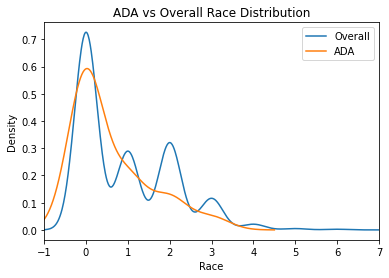

In [149]:
plot_ldr_density(df_pred_ada_ldr, 'ADA')
df_ada_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.525,21
1,0.195000,234,0.225,9
2,0.216667,260,0.150,6
3,0.078333,94,0.100,4
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


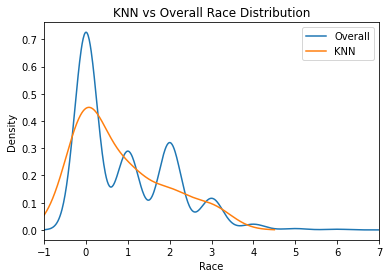

In [150]:
plot_ldr_density(df_pred_knn_ldr, 'KNN')
df_knn_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.550,22
1,0.195000,234,0.200,8
2,0.216667,260,0.175,7
3,0.078333,94,0.075,3
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


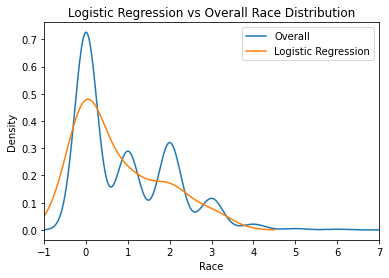

In [151]:
plot_ldr_density(df_pred_logistic_ldr, 'Logistic Regression')
df_logistic_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.675,27
1,0.195000,234,0.150,6
2,0.216667,260,0.075,3
3,0.078333,94,0.075,3
4,0.014167,17,0.025,1
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


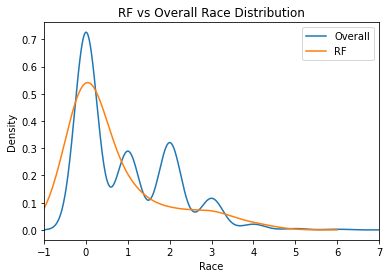

In [152]:
plot_ldr_density(df_pred_rf_ldr, 'RF')
df_rf_ldr_race_disparity

# Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.993566,0.506468,0.950833,0.0,0.97,0.920833,0.03,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \...


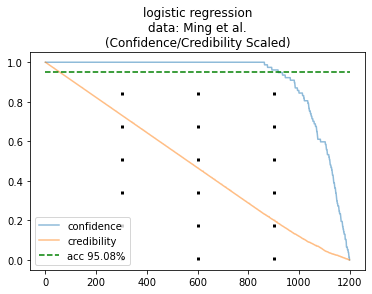

In [6]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic = util.run_experiments(cc, 
                                           tab_signal, 
                                           tab_signal, 
                                           tab_signal, 
                                           eps=0.05, 
                                           method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic, data_title='Ming et al.')
experiment_logistic

---
## Get Lower Decile Range (LDR) - `confidence`/`credibility`

In [7]:
df_pred_logistic = experiment_logistic.loc[0, 'df']
df_pred_logistic = util.sort_reindex(df_pred_logistic, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_logistic.index.values) / 10)
df_pred_logistic_ldr = df_pred_logistic.iloc[-ldr_idx:,:]
df_pred_logistic_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1080,[0],0.974188,0.125729,0.05,"[(0.1257285595337219, 0), (0.02581182348043297...",True,-0.513143,1,0,2.432804,-0.474771,2,1,0
1081,[1],0.974188,0.124896,0.05,"[(0.025811823480432972, 0), (0.124895920066611...",True,-0.114714,1,0,-0.440587,-0.509225,2,3,1
1082,[1],0.974188,0.124063,0.05,"[(0.025811823480432972, 0), (0.124063280599500...",True,0.283714,0,2,-1.398384,2.040345,0,1,1
1083,[1],0.974188,0.124063,0.05,"[(0.025811823480432972, 0), (0.124063280599500...",True,0.283714,0,2,-1.398384,2.040345,0,1,1
1084,[1],0.974188,0.122398,0.05,"[(0.025811823480432972, 0), (0.122398001665278...",True,0.084500,0,2,-1.398384,-0.509225,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,"[0, 1]",0.937552,0.066611,0.05,"[(0.06661115736885928, 0), (0.0624479600333055...",True,0.084500,0,2,0.517210,-0.474771,0,1,1
1196,"[0, 1]",0.936719,0.065779,0.05,"[(0.06577851790174855, 0), (0.0632805995004163...",True,0.084500,0,2,0.517210,-0.405864,0,1,1
1197,"[0, 1]",0.935887,0.065779,0.05,"[(0.06577851790174855, 0), (0.0641132389675270...",True,0.084500,0,2,-0.440587,-0.440318,1,1,1
1198,"[0, 1]",0.935887,0.065779,0.05,"[(0.06577851790174855, 0), (0.0641132389675270...",True,-0.313929,1,0,0.517210,2.040345,2,0,0


----
### Get `Race` distribution in LDR

In [8]:
logistic_ldr_race_counts = df_pred_logistic_ldr.Race.value_counts().sort_index()
n_logistic_ldr_race = logistic_ldr_race_counts.values.sum()
logistic_ldr_race_prop = pd.DataFrame({'low_confidence_p': logistic_ldr_race_counts / n_logistic_ldr_race, 
                                       'low_confidence_n': logistic_ldr_race_counts})
df_logistic_ldr_race_disparity = df_race_signal_prop.join(logistic_ldr_race_prop, on='race', how='left')
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.fillna(0)
df_logistic_ldr_race_disparity['low_confidence_n'] = df_logistic_ldr_race_disparity['low_confidence_n'].astype(int)
df_logistic_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,589,0.490833,0.490662,0.416667,50
1,234,0.195000,0.478632,0.275000,33
2,260,0.216667,0.526923,0.208333,25
3,94,0.078333,0.510638,0.100000,12
4,17,0.014167,0.647059,0.000000,0
5,4,0.003333,0.500000,0.000000,0
6,2,0.001667,0.000000,0.000000,0


#### Observation:

- most prevalent `race` 0 is __under-represented__ in low confidence region
    - `count_p` = 0.490833, whereas `low_confidence_p` = 0.416667
- 3rd most prevalent `race` 1 is __over-represented__ in low confidence region
    - `count_p` = 0.195, whereas `low_confidence_p` = 0.275
- 2nd most prevalent `race` 2 is fairly well represented in low confidence region
    - `count_p` = 0.216667, whereas `low_confidence_p` = 0.208333
- 4th most prevalent `race` 3 is __slightly over-represented__ in low confidence region
    - `count_p` = 0.078333, whereas `low_confidence_p` = 0.1
- 5th/6th/7th most prevalent `race` 4/5/6, respectively, are __not represented__ in low confidence region 

----

Consider missing `race` cases with respect to correlation coefficients

----

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


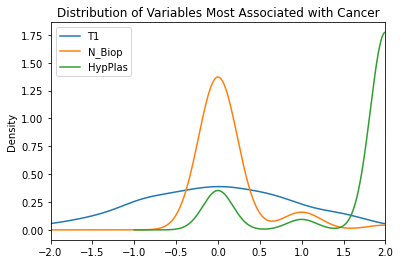

In [76]:
df_pred_logistic.loc[:,['T1','N_Biop','HypPlas']].plot(kind='density', 
                                                       xlim=(-2,2), 
                                                       title='Distribution of Variables Most Associated with Cancer')
df_cancer_X_correlation_matrix

In [62]:
df_pred_logistic[df_pred_logistic.Race > 3].loc[:,['Race', 'T1', 'N_Biop', 'HypPlas', 'class', 
                                                   'classes', 'confidence', 'credibility']
                                               ].sort_values(['Race', 'confidence', 'credibility'], 
                                                             ascending=False).head(10)

,Race,T1,N_Biop,HypPlas,class,classes,confidence,credibility
52,6,-1.907643,0,2,0,[0],0.999167,0.956703
308,6,-1.110786,0,2,0,[0],0.999167,0.743547
73,5,-1.708429,0,2,0,[0],0.999167,0.939217
77,5,1.479000,3,1,1,[1],0.999167,0.935887
94,5,-1.708429,0,2,0,[0],0.999167,0.921732
593,5,0.682143,0,2,1,[1],0.999167,0.506245
125,4,1.678215,0,2,1,[1],0.999167,0.895920
136,4,1.279786,3,0,1,[1],0.999167,0.886761
184,4,-1.708429,3,0,0,[0],0.999167,0.846794
209,4,1.479000,0,2,1,[1],0.999167,0.825978


#### Conclusion:

It appears the lack of `race` 4/5/6 may be due to the fact that the particular individuals of these races in the population sample happen to have one or more risk-factor values that are strongly associated with one outcome or the other (Cancer/Healthy).

Increasing sample size may be sufficient to mitigate what appears to be an unlikely scenario.

# Read in Data (10x sample size)

In [79]:
tab_signal = normalizer(Orange.data.Table('./data/signal_10x_with_header_for_orange.csv'))

----
## Get `Race` distribution and cancer occurrence in population sample

In [80]:
# get distribution of race
df_race_signal = pd.DataFrame()
df_race_signal['race'] = tab_signal.X[:,-1].astype(int)
df_race_signal_counts = df_race_signal.value_counts().sort_index()
n_signal_race = df_race_signal_counts.values.sum()

# get occurrence of cancer by race
df_race_signal['cancer'] = tab_signal.Y.astype(int)
p_cancer_by_race = df_race_signal.groupby('race').mean('cancer')

df_race_signal_prop = pd.DataFrame({'count_n': df_race_signal_counts,
                                    'count_p': df_race_signal_counts / n_signal_race,                                    
                                    'cancer': p_cancer_by_race.values.flatten()})
df_race_signal_prop

,count_n,count_p,cancer
race,,,
0,6043,0.503583,0.505378
1,2397,0.199750,0.487693
2,2366,0.197167,0.502959
3,935,0.077917,0.499465
4,126,0.010500,0.436508
5,68,0.005667,0.352941
6,65,0.005417,0.476923


## Get Cancer (`Case_signalYN`) Correlation with Independent Variables

In [44]:
# previous correlation 
df_cancer_X_correlation_matrix

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


In [83]:
df_tab_signal = util.table_to_df(tab_signal, x_only=False)
df_cancer_X_correlation_matrix = pd.DataFrame(df_tab_signal.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.767549,0.081638,-0.073791,0.050976,-0.004405,0.061774,-0.014273,1.0


Without changing the original function to determine `Case_signalYN` defined by Ming et al. (which included random noise), there is no immediately apparent means to correct the sign change of correlation coefficients corresponding to `Age1st` and `Race` with the 10x sample size. However, these were the two variables least associated with Cancer in our prior population sample. As such, we shall proceed. 

----

# Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.991913,0.508163,0.950083,0.0,0.93375,0.883833,0.06625,signal_10x_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps ...


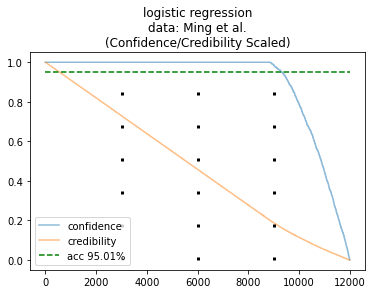

In [84]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic = util.run_experiments(cc, 
                                           tab_signal, 
                                           tab_signal, 
                                           tab_signal, 
                                           eps=0.05, 
                                           method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic, data_title='Ming et al.')
experiment_logistic

---
## Get Lower Decile Range (LDR) - `confidence`/`credibility`

In [85]:
df_pred_logistic = experiment_logistic.loc[0, 'df']
df_pred_logistic = util.sort_reindex(df_pred_logistic, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_logistic.index.values) / 10)
df_pred_logistic_ldr = df_pred_logistic.iloc[-ldr_idx:,:]
df_pred_logistic_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
10800,[0],0.963336,0.136822,0.05,"[(0.13682193150570784, 0), (0.0366636113657195...",True,-0.095374,0,2,1.442897,1.991612,0,0,0
10801,[0],0.963336,0.136822,0.05,"[(0.13682193150570784, 0), (0.0366636113657195...",True,-0.095374,0,2,1.442897,1.991612,0,0,0
10802,[0],0.963253,0.136489,0.05,"[(0.13648862594783767, 0), (0.0367469377551870...",False,-0.492077,3,0,1.442897,-0.484463,0,0,1
10803,[1],0.963170,0.136489,0.05,"[(0.03683026414465461, 0), (0.1364886259478376...",False,0.102977,0,2,1.442897,1.991612,1,0,0
10804,[0],0.963086,0.136489,0.05,"[(0.13648862594783767, 0), (0.0369135905341221...",False,-0.095374,0,2,-1.451258,-0.450544,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,"[0, 1]",0.922173,0.078160,0.05,"[(0.07782684776268645, 0), (0.0781601533205566...",True,-0.095374,1,0,0.478179,-0.450544,1,0,0
11996,"[0, 1]",0.922173,0.078160,0.05,"[(0.07782684776268645, 0), (0.0781601533205566...",True,-0.095374,1,0,0.478179,-0.450544,1,0,1
11997,"[0, 1]",0.922173,0.078077,0.05,"[(0.07782684776268645, 0), (0.0780768269310890...",True,-0.095374,1,0,0.478179,-0.416625,1,0,1
11998,"[0, 1]",0.922173,0.077994,0.05,"[(0.07799350054162153, 0), (0.0778268477626864...",True,-0.095374,0,2,0.478179,1.991612,4,2,0


----
### Get `Race` distribution in LDR

In [86]:
logistic_ldr_race_counts = df_pred_logistic_ldr.Race.value_counts().sort_index()
n_logistic_ldr_race = logistic_ldr_race_counts.values.sum()
logistic_ldr_race_prop = pd.DataFrame({'low_confidence_p': logistic_ldr_race_counts / n_logistic_ldr_race, 
                                       'low_confidence_n': logistic_ldr_race_counts})
df_logistic_ldr_race_disparity = df_race_signal_prop.join(logistic_ldr_race_prop, on='race', how='left')
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.fillna(0)
df_logistic_ldr_race_disparity['low_confidence_n'] = df_logistic_ldr_race_disparity['low_confidence_n'].astype(int)
df_logistic_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,6043,0.503583,0.505378,0.489167,587
1,2397,0.199750,0.487693,0.207500,249
2,2366,0.197167,0.502959,0.205000,246
3,935,0.077917,0.499465,0.070833,85
4,126,0.010500,0.436508,0.014167,17
5,68,0.005667,0.352941,0.005833,7
6,65,0.005417,0.476923,0.007500,9


----
Plot population race distribution

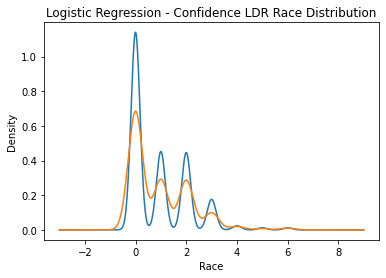

In [102]:
pop_race = df_race_signal['race']
pop_race.plot(kind='density', title='Overall Race Distribution')
ldr_race = df_pred_logistic_ldr.Race
ldr_race.plot(kind='density', title='Logistic Regression - Confidence LDR Race Distribution')
plt.xlabel('Race')
print()

In [ ]:
// TODO below revisit with above new results

#### Observation:

- most prevalent `race` 0 is __-represented__ in low confidence region
    - `count_p` = 0.490833, whereas `low_confidence_p` = 0.416667
- 3rd most prevalent `race` 1 is __-represented__ in low confidence region
    - `count_p` = 0.195, whereas `low_confidence_p` = 0.275
- 2nd most prevalent `race` 2 is - represented in low confidence region
    - `count_p` = 0.216667, whereas `low_confidence_p` = 0.208333
- 4th most prevalent `race` 3 is __-represented__ in low confidence region
    - `count_p` = 0.078333, whereas `low_confidence_p` = 0.1
- 5th/6th/7th most prevalent `race` 4/5/6, respectively, are __- represented__ in low confidence region 

----

Consider missing `race` cases with respect to correlation coefficients

----

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


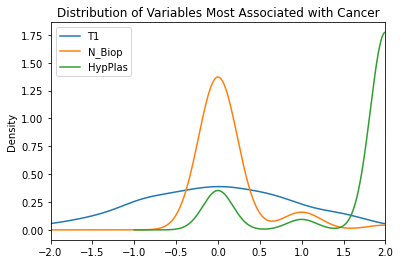

In [76]:
df_pred_logistic.loc[:,['T1','N_Biop','HypPlas']].plot(kind='density', 
                                                       xlim=(-2,2), 
                                                       title='Distribution of Variables Most Associated with Cancer')
df_cancer_X_correlation_matrix

In [87]:
df_pred_logistic[df_pred_logistic.Race > 3].loc[:,['Race', 'T1', 'N_Biop', 'HypPlas', 'class', 
                                                   'classes', 'confidence', 'credibility']
                                               ].sort_values(['Race', 'confidence', 'credibility'], 
                                                             ascending=False).head(10)

,Race,T1,N_Biop,HypPlas,class,classes,confidence,credibility
33,6,2.681546,4,1,1,[1],0.999917,0.997250
139,6,2.483194,0,2,1,[1],0.999917,0.988418
220,6,2.483194,0,2,1,[1],0.999917,0.981668
221,6,-2.277240,0,2,0,[0],0.999917,0.981585
440,6,-2.078888,0,2,0,[0],0.999917,0.963336
441,6,-2.078888,0,2,0,[0],0.999917,0.963336
505,6,-2.078888,0,2,0,[0],0.999917,0.957920
809,6,1.888140,0,2,1,[1],0.999917,0.932589
949,6,1.888140,0,2,1,[1],0.999917,0.920923
1081,6,-1.682185,0,2,0,[0],0.999917,0.909924


#### Conclusion:



----

----

----

# Random Forest
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.998612,0.824756,0.956667,0.038333,0.961667,0.956667,0.0,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),Baseline Unsplit Data,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \...


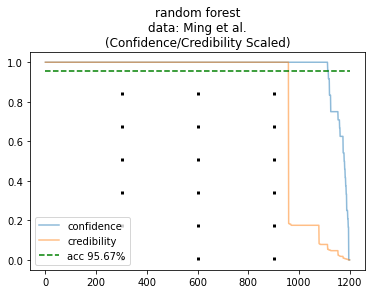

In [9]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.RandomForestLearner(random_state=42)))

experiment_rf = util.run_experiments(cc, 
                                     tab_signal, 
                                     tab_signal, 
                                     tab_signal, 
                                     eps=0.05, 
                                     method='Baseline Unsplit Data')

util.plot_experiments(experiment_rf, data_title='Ming et al.')
experiment_rf

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.997174,0.803856,0.95075,0.008417,0.991583,0.95075,0.0,signal_10x_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),Baseline Unsplit Data,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps ...


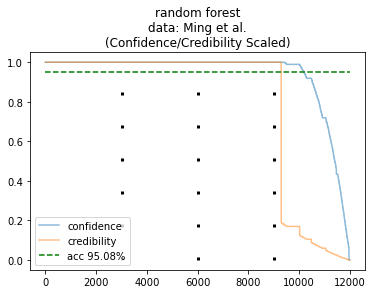

In [88]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.RandomForestLearner(random_state=42)))

experiment_rf = util.run_experiments(cc, 
                                     tab_signal, 
                                     tab_signal, 
                                     tab_signal, 
                                     eps=0.05, 
                                     method='Baseline Unsplit Data')

util.plot_experiments(experiment_rf, data_title='Ming et al.')
experiment_rf

---
## Get Lower Decile Range (LDR) - `confidence`/`credibility`

In [10]:
df_pred_rf = experiment_rf.loc[0, 'df']
df_pred_rf = util.sort_reindex(df_pred_rf, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_rf.index.values) / 10)
df_pred_rf_ldr = df_pred_rf.iloc[-ldr_idx:,:]
df_pred_rf_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1080,[1],0.999167,0.100749,0.05,"[(0.0008326394671107411, 0), (0.10074937552039...",True,0.084500,0,2,0.517210,-0.474771,2,1,1
1081,[1],0.999167,0.099917,0.05,"[(0.0008326394671107411, 0), (0.09991673605328...",True,0.084500,0,2,-1.398384,-0.371410,1,0,1
1082,[1],0.999167,0.099084,0.05,"[(0.0008326394671107411, 0), (0.09908409658617...",True,0.084500,0,2,-0.440587,-0.474771,3,0,1
1083,[0],0.999167,0.099084,0.05,"[(0.09908409658617819, 0), (0.0008326394671107...",True,0.084500,0,2,-0.440587,-0.440318,3,3,0
1084,[1],0.999167,0.097419,0.05,"[(0.0008326394671107411, 0), (0.09741881765195...",True,0.084500,0,2,0.517210,-0.405864,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,[],0.982515,0.021649,0.05,"[(0.02164862614487927, 0), (0.0174854288093255...",False,-0.114714,0,2,0.517210,-0.509225,0,2,1
1196,[],0.979184,0.020816,0.05,"[(0.020815986677768527, 0), (0.020815986677768...",False,0.283714,0,2,-0.440587,-0.509225,0,4,0
1197,[],0.979184,0.020816,0.05,"[(0.020815986677768527, 0), (0.020815986677768...",False,0.283714,0,2,-2.356181,-0.543679,0,2,0
1198,[],0.979184,0.020816,0.05,"[(0.020815986677768527, 0), (0.020815986677768...",False,0.283714,0,2,-1.398384,-0.440318,2,1,0


In [89]:
df_pred_rf = experiment_rf.loc[0, 'df']
df_pred_rf = util.sort_reindex(df_pred_rf, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_rf.index.values) / 10)
df_pred_rf_ldr = df_pred_rf.iloc[-ldr_idx:,:]
df_pred_rf_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
10800,[1],0.990167,0.109908,0.05,"[(0.009832513957170236, 0), (0.109907507707691...",False,0.301329,0,2,0.478179,-0.586219,1,0,0
10801,[1],0.990167,0.109908,0.05,"[(0.009832513957170236, 0), (0.109907507707691...",True,-0.095374,1,0,0.478179,-0.552300,0,1,1
10802,[1],0.990167,0.109908,0.05,"[(0.009832513957170236, 0), (0.109907507707691...",True,0.301329,0,2,0.478179,-0.586219,1,0,1
10803,[1],0.990167,0.109908,0.05,"[(0.009832513957170236, 0), (0.109907507707691...",True,0.301329,0,2,0.478179,-0.586219,1,0,1
10804,[1],0.989834,0.109491,0.05,"[(0.010165819515040413, 0), (0.109490875760353...",True,0.301329,0,2,-0.486540,-0.484463,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,[],0.953671,0.046329,0.05,"[(0.04632947254395467, 0), (0.0463294725439546...",False,-0.293725,3,1,1.442897,-0.484463,3,0,1
11996,[],0.953671,0.046329,0.05,"[(0.04632947254395467, 0), (0.0463294725439546...",False,0.301329,0,2,-0.486540,-0.518381,0,3,0
11997,[],0.953671,0.046329,0.05,"[(0.04632947254395467, 0), (0.0463294725439546...",False,-0.293725,1,0,1.442897,-0.586219,3,0,1
11998,[],0.953671,0.046329,0.05,"[(0.04632947254395467, 0), (0.0463294725439546...",False,-0.095374,0,2,-1.451258,-0.552300,0,5,1


----
### Get `Race` distribution in LDR

In [11]:
rf_ldr_race_counts = df_pred_rf_ldr.Race.value_counts().sort_index()
n_rf_ldr_race = rf_ldr_race_counts.values.sum()
rf_ldr_race_prop = pd.DataFrame({'low_confidence_p': rf_ldr_race_counts / n_rf_ldr_race, 
                                 'low_confidence_n': rf_ldr_race_counts})
df_rf_ldr_race_disparity = df_race_signal_prop.join(rf_ldr_race_prop, on='race', how='left')
df_rf_ldr_race_disparity = df_rf_ldr_race_disparity.fillna(0)
df_rf_ldr_race_disparity['low_confidence_n'] = df_rf_ldr_race_disparity['low_confidence_n'].astype(int)
df_rf_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,589,0.490833,0.490662,0.500000,60
1,234,0.195000,0.478632,0.191667,23
2,260,0.216667,0.526923,0.175000,21
3,94,0.078333,0.510638,0.125000,15
4,17,0.014167,0.647059,0.008333,1
5,4,0.003333,0.500000,0.000000,0
6,2,0.001667,0.000000,0.000000,0


In [90]:
rf_ldr_race_counts = df_pred_rf_ldr.Race.value_counts().sort_index()
n_rf_ldr_race = rf_ldr_race_counts.values.sum()
rf_ldr_race_prop = pd.DataFrame({'low_confidence_p': rf_ldr_race_counts / n_rf_ldr_race, 
                                 'low_confidence_n': rf_ldr_race_counts})
df_rf_ldr_race_disparity = df_race_signal_prop.join(rf_ldr_race_prop, on='race', how='left')
df_rf_ldr_race_disparity = df_rf_ldr_race_disparity.fillna(0)
df_rf_ldr_race_disparity['low_confidence_n'] = df_rf_ldr_race_disparity['low_confidence_n'].astype(int)
df_rf_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,6043,0.503583,0.505378,0.549167,659
1,2397,0.199750,0.487693,0.198333,238
2,2366,0.197167,0.502959,0.189167,227
3,935,0.077917,0.499465,0.047500,57
4,126,0.010500,0.436508,0.008333,10
5,68,0.005667,0.352941,0.004167,5
6,65,0.005417,0.476923,0.003333,4


#### Conclusion:



----

----

----

# ADA
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.994586,0.505934,0.953333,0.0,0.984167,0.9375,0.015833,signal_with_header_for_orange,False,ada boost classification,InductiveClassifier (InverseProbability (ada b...,InverseProbability (ada boost classification),Baseline Unsplit Data,SklAdaBoostClassifier(skl_model=AdaBoostClassi...,InductiveClassifier (InverseProbability (ada b...,classes confidence credibility eps \...


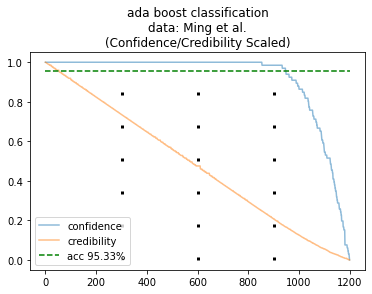

In [12]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.modelling.ada_boost.SklAdaBoostClassificationLearner(random_state=42)))

experiment_ada = util.run_experiments(cc, 
                                      tab_signal, 
                                      tab_signal, 
                                      tab_signal, 
                                      eps=0.05, 
                                      method='Baseline Unsplit Data')

util.plot_experiments(experiment_ada, data_title='Ming et al.')
experiment_ada

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.991765,0.508793,0.950667,0.0,0.933417,0.884083,0.066583,signal_10x_with_header_for_orange,False,ada boost classification,InductiveClassifier (InverseProbability (ada b...,InverseProbability (ada boost classification),Baseline Unsplit Data,SklAdaBoostClassifier(skl_model=AdaBoostClassi...,InductiveClassifier (InverseProbability (ada b...,classes confidence credibility eps ...


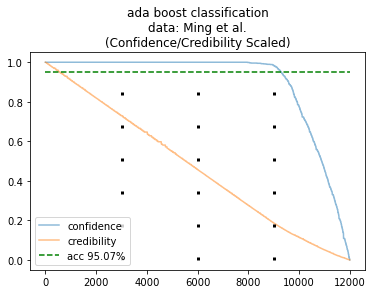

In [91]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.modelling.ada_boost.SklAdaBoostClassificationLearner(random_state=42)))

experiment_ada = util.run_experiments(cc, 
                                      tab_signal, 
                                      tab_signal, 
                                      tab_signal, 
                                      eps=0.05, 
                                      method='Baseline Unsplit Data')

util.plot_experiments(experiment_ada, data_title='Ming et al.')
experiment_ada

---
## Get Lower Decile Range (LDR) - `confidence`/`credibility`

In [13]:
df_pred_ada = experiment_ada.loc[0, 'df']
df_pred_ada = util.sort_reindex(df_pred_ada, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_ada.index.values) / 10)
df_pred_ada_ldr = df_pred_ada.iloc[-ldr_idx:,:]
df_pred_ada_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1080,[0],0.980849,0.119067,0.05,"[(0.11906744379683597, 0), (0.0191507077435470...",True,-0.114714,0,2,1.475007,-0.509225,1,1,0
1081,[0],0.980849,0.118235,0.05,"[(0.11823480432972523, 0), (0.0191507077435470...",True,-0.313929,1,0,0.517210,-0.509225,0,2,0
1082,[0],0.980849,0.117402,0.05,"[(0.11740216486261448, 0), (0.0191507077435470...",True,-0.313929,0,2,-0.440587,-0.509225,3,2,0
1083,[1],0.980017,0.116570,0.05,"[(0.019983347210657785, 0), (0.116569525395503...",True,0.283714,0,2,-0.440587,-0.440318,0,3,1
1084,[1],0.980017,0.116570,0.05,"[(0.019983347210657785, 0), (0.116569525395503...",False,0.283714,0,2,-0.440587,-0.440318,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,"[0, 1]",0.945878,0.057452,0.05,"[(0.05745212323064113, 0), (0.0541215653621981...",True,0.084500,0,2,-0.440587,2.040345,0,0,0
1196,"[0, 1]",0.945878,0.057452,0.05,"[(0.05412156536219817, 0), (0.0574521232306411...",True,-0.712357,3,0,2.432804,-0.509225,3,1,0
1197,"[0, 1]",0.945878,0.057452,0.05,"[(0.05745212323064113, 0), (0.0541215653621981...",True,0.084500,0,2,-0.440587,2.040345,0,0,0
1198,"[0, 1]",0.945046,0.055787,0.05,"[(0.05578684429641965, 0), (0.0549542048293089...",True,0.084500,0,2,-0.440587,-0.440318,1,1,1


In [92]:
df_pred_ada = experiment_ada.loc[0, 'df']
df_pred_ada = util.sort_reindex(df_pred_ada, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_ada.index.values) / 10)
df_pred_ada_ldr = df_pred_ada.iloc[-ldr_idx:,:]
df_pred_ada_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
10800,[0],0.962753,0.137239,0.05,"[(0.13723856345304558, 0), (0.0372468960919923...",True,-0.293725,3,0,-1.451258,-0.450544,0,3,0
10801,[1],0.962753,0.137155,0.05,"[(0.03724689609199233, 0), (0.1371552370635780...",True,0.102977,1,1,-0.486540,-0.484463,0,0,1
10802,[1],0.962670,0.137072,0.05,"[(0.037330222481459875, 0), (0.137071910674110...",False,-0.095374,2,1,-0.486540,1.991612,0,3,0
10803,[1],0.962670,0.137072,0.05,"[(0.037330222481459875, 0), (0.137071910674110...",True,-0.095374,2,1,-0.486540,-0.348787,0,0,1
10804,[0],0.962670,0.136989,0.05,"[(0.13698858428464294, 0), (0.0373302224814598...",True,-0.888780,5,1,2.407616,1.991612,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,"[0, 1]",0.921007,0.079327,0.05,"[(0.07932672277310224, 0), (0.0789934172152320...",True,-0.095374,0,2,-0.486540,-0.450544,2,1,0
11996,"[0, 1]",0.921007,0.079327,0.05,"[(0.07932672277310224, 0), (0.0789934172152320...",True,-0.095374,0,2,-0.486540,-0.450544,2,1,1
11997,"[0, 1]",0.920923,0.079243,0.05,"[(0.0792433963836347, 0), (0.07907674360469961...",True,0.102977,1,0,-1.451258,1.991612,1,0,1
11998,"[0, 1]",0.920840,0.079243,0.05,"[(0.0792433963836347, 0), (0.07916006999416715...",True,-0.293725,1,0,1.442897,-0.518381,2,0,1


----
### Get `Race` distribution in LDR

In [14]:
ada_ldr_race_counts = df_pred_ada_ldr.Race.value_counts().sort_index()
n_ada_ldr_race = ada_ldr_race_counts.values.sum()
ada_ldr_race_prop = pd.DataFrame({'low_confidence_p': ada_ldr_race_counts / n_ada_ldr_race, 
                                 'low_confidence_n': ada_ldr_race_counts})
df_ada_ldr_race_disparity = df_race_signal_prop.join(ada_ldr_race_prop, on='race', how='left')
df_ada_ldr_race_disparity = df_ada_ldr_race_disparity.fillna(0)
df_ada_ldr_race_disparity['low_confidence_n'] = df_ada_ldr_race_disparity['low_confidence_n'].astype(int)
df_ada_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,589,0.490833,0.490662,0.425000,51
1,234,0.195000,0.478632,0.291667,35
2,260,0.216667,0.526923,0.166667,20
3,94,0.078333,0.510638,0.108333,13
4,17,0.014167,0.647059,0.008333,1
5,4,0.003333,0.500000,0.000000,0
6,2,0.001667,0.000000,0.000000,0


In [93]:
ada_ldr_race_counts = df_pred_ada_ldr.Race.value_counts().sort_index()
n_ada_ldr_race = ada_ldr_race_counts.values.sum()
ada_ldr_race_prop = pd.DataFrame({'low_confidence_p': ada_ldr_race_counts / n_ada_ldr_race, 
                                 'low_confidence_n': ada_ldr_race_counts})
df_ada_ldr_race_disparity = df_race_signal_prop.join(ada_ldr_race_prop, on='race', how='left')
df_ada_ldr_race_disparity = df_ada_ldr_race_disparity.fillna(0)
df_ada_ldr_race_disparity['low_confidence_n'] = df_ada_ldr_race_disparity['low_confidence_n'].astype(int)
df_ada_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,6043,0.503583,0.505378,0.480833,577
1,2397,0.199750,0.487693,0.211667,254
2,2366,0.197167,0.502959,0.207500,249
3,935,0.077917,0.499465,0.072500,87
4,126,0.010500,0.436508,0.013333,16
5,68,0.005667,0.352941,0.006667,8
6,65,0.005417,0.476923,0.007500,9


#### Conclusion:



----

----

----

# KNN
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.983268,0.736306,0.985833,0.0,0.833333,0.819167,0.166667,signal_with_header_for_orange,False,knn,InductiveClassifier (InverseProbability (knn)),InverseProbability (knn),Baseline Unsplit Data,SklModelClassification(skl_model=KNeighborsCla...,InductiveClassifier (InverseProbability (knn)),classes confidence credibility eps \...


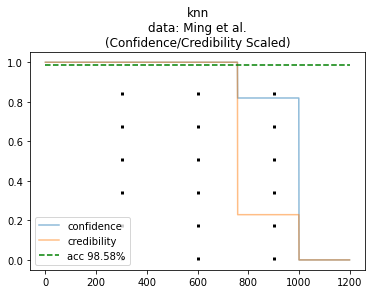

In [15]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.knn.KNNLearner()))

experiment_knn = util.run_experiments(cc, 
                                      tab_signal, 
                                      tab_signal, 
                                      tab_signal, 
                                      eps=0.05, 
                                      method='Baseline Unsplit Data')

util.plot_experiments(experiment_knn, data_title='Ming et al.')
experiment_knn

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.987121,0.785302,0.977083,0.0,0.87525,0.852333,0.12475,signal_10x_with_header_for_orange,False,knn,InductiveClassifier (InverseProbability (knn)),InverseProbability (knn),Baseline Unsplit Data,SklModelClassification(skl_model=KNeighborsCla...,InductiveClassifier (InverseProbability (knn)),classes confidence credibility eps ...


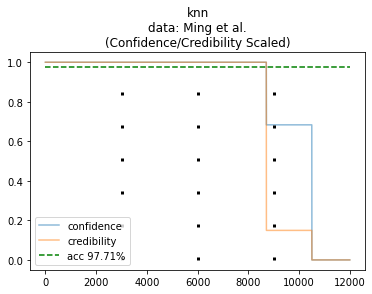

In [94]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.knn.KNNLearner()))

experiment_knn = util.run_experiments(cc, 
                                      tab_signal, 
                                      tab_signal, 
                                      tab_signal, 
                                      eps=0.05, 
                                      method='Baseline Unsplit Data')

util.plot_experiments(experiment_knn, data_title='Ming et al.')
experiment_knn

---
## Get Lower Decile Range (LDR) - `confidence`/`credibility`

In [16]:
df_pred_knn = experiment_knn.loc[0, 'df']
df_pred_knn = util.sort_reindex(df_pred_knn, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_knn.index.values) / 10)
df_pred_knn_ldr = df_pred_knn.iloc[-ldr_idx:,:]
df_pred_knn_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1080,"[0, 1]",0.920899,0.181515,0.05,"[(0.0791007493755204, 0), (0.18151540383014156...",True,-0.114714,3,0,-0.440587,-0.474771,0,3,0
1081,"[0, 1]",0.920899,0.181515,0.05,"[(0.18151540383014156, 0), (0.0791007493755204...",True,-0.513143,0,2,1.475007,-0.578132,3,0,0
1082,"[0, 1]",0.920899,0.181515,0.05,"[(0.0791007493755204, 0), (0.18151540383014156...",True,-0.114714,1,0,-0.440587,-0.578132,2,1,0
1083,"[0, 1]",0.920899,0.181515,0.05,"[(0.0791007493755204, 0), (0.18151540383014156...",True,0.084500,1,0,2.432804,-0.405864,0,2,1
1084,"[0, 1]",0.920899,0.181515,0.05,"[(0.18151540383014156, 0), (0.0791007493755204...",True,0.283714,0,2,1.475007,-0.474771,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,"[0, 1]",0.920899,0.181515,0.05,"[(0.18151540383014156, 0), (0.0791007493755204...",True,0.283714,0,2,0.517210,-0.440318,0,0,0
1196,"[0, 1]",0.920899,0.181515,0.05,"[(0.18151540383014156, 0), (0.0791007493755204...",True,-0.114714,0,2,-1.398384,-0.543679,2,1,0
1197,"[0, 1]",0.920899,0.181515,0.05,"[(0.0791007493755204, 0), (0.18151540383014156...",True,-0.313929,1,0,0.517210,-0.509225,0,2,0
1198,"[0, 1]",0.920899,0.181515,0.05,"[(0.0791007493755204, 0), (0.18151540383014156...",True,0.881357,0,2,0.517210,-0.509225,3,0,1


In [95]:
df_pred_knn = experiment_knn.loc[0, 'df']
df_pred_knn = util.sort_reindex(df_pred_knn, col=['confidence','credibility'])
ldr_idx = int(len(df_pred_knn.index.values) / 10)
df_pred_knn_ldr = df_pred_knn.iloc[-ldr_idx:,:]
df_pred_knn_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
10800,"[0, 1]",0.929173,0.147738,0.05,"[(0.07082743104741271, 0), (0.1477376885259561...",True,0.301329,1,1,-0.486540,-0.484463,0,0,1
10801,"[0, 1]",0.929173,0.147738,0.05,"[(0.07082743104741271, 0), (0.1477376885259561...",True,-0.492077,0,2,0.478179,1.991612,4,0,0
10802,"[0, 1]",0.929173,0.147738,0.05,"[(0.07082743104741271, 0), (0.1477376885259561...",True,0.102977,0,2,-0.486540,-0.552300,0,0,0
10803,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,-0.492077,1,1,0.478179,-0.450544,0,1,0
10804,"[0, 1]",0.929173,0.147738,0.05,"[(0.07082743104741271, 0), (0.1477376885259561...",True,-0.095374,1,0,-0.486540,-0.620138,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,0.102977,0,2,-0.486540,-0.552300,0,2,0
11996,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,-0.095374,0,2,0.478179,-0.450544,1,2,1
11997,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,-0.095374,0,2,-0.486540,-0.586219,1,3,1
11998,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,0.102977,0,2,-0.486540,-0.518381,0,0,0


----
### Get `Race` distribution in LDR

In [17]:
knn_ldr_race_counts = df_pred_knn_ldr.Race.value_counts().sort_index()
n_knn_ldr_race = knn_ldr_race_counts.values.sum()
knn_ldr_race_prop = pd.DataFrame({'low_confidence_p': knn_ldr_race_counts / n_knn_ldr_race, 
                                 'low_confidence_n': knn_ldr_race_counts})
df_knn_ldr_race_disparity = df_race_signal_prop.join(knn_ldr_race_prop, on='race', how='left')
df_knn_ldr_race_disparity = df_knn_ldr_race_disparity.fillna(0)
df_knn_ldr_race_disparity['low_confidence_n'] = df_knn_ldr_race_disparity['low_confidence_n'].astype(int)
df_knn_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,589,0.490833,0.490662,0.500000,60
1,234,0.195000,0.478632,0.233333,28
2,260,0.216667,0.526923,0.133333,16
3,94,0.078333,0.510638,0.116667,14
4,17,0.014167,0.647059,0.016667,2
5,4,0.003333,0.500000,0.000000,0
6,2,0.001667,0.000000,0.000000,0


In [96]:
knn_ldr_race_counts = df_pred_knn_ldr.Race.value_counts().sort_index()
n_knn_ldr_race = knn_ldr_race_counts.values.sum()
knn_ldr_race_prop = pd.DataFrame({'low_confidence_p': knn_ldr_race_counts / n_knn_ldr_race, 
                                 'low_confidence_n': knn_ldr_race_counts})
df_knn_ldr_race_disparity = df_race_signal_prop.join(knn_ldr_race_prop, on='race', how='left')
df_knn_ldr_race_disparity = df_knn_ldr_race_disparity.fillna(0)
df_knn_ldr_race_disparity['low_confidence_n'] = df_knn_ldr_race_disparity['low_confidence_n'].astype(int)
df_knn_ldr_race_disparity

,count_n,count_p,cancer,low_confidence_p,low_confidence_n
race,,,,,
0,6043,0.503583,0.505378,0.470833,565
1,2397,0.199750,0.487693,0.207500,249
2,2366,0.197167,0.502959,0.220000,264
3,935,0.077917,0.499465,0.066667,80
4,126,0.010500,0.436508,0.016667,20
5,68,0.005667,0.352941,0.008333,10
6,65,0.005417,0.476923,0.010000,12


In [97]:
df_pred_knn[df_pred_knn.Race>4]

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
41,[0],0.999167,1.000000,0.05,"[(1.0, 0), (0.0008332638946754438, 1)]",True,-1.483834,0,2,-0.486540,-0.416625,0,6,0
89,[1],0.999167,1.000000,0.05,"[(0.0008332638946754438, 0), (1.0, 1)]",True,0.301329,0,2,0.478179,-0.518381,0,6,1
106,[0],0.999167,1.000000,0.05,"[(1.0, 0), (0.0008332638946754438, 1)]",True,-0.888780,0,2,-0.486540,-0.484463,0,6,0
227,[1],0.999167,1.000000,0.05,"[(0.0008332638946754438, 0), (1.0, 1)]",True,1.888140,0,2,0.478179,-0.484463,0,6,1
248,[0],0.999167,1.000000,0.05,"[(1.0, 0), (0.0008332638946754438, 1)]",True,-0.492077,0,2,-0.486540,-0.450544,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11910,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,-0.492077,0,2,0.478179,1.991612,0,5,0
11919,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,0.102977,0,2,-0.486540,-0.382706,0,6,0
11931,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,-0.095374,0,2,-1.451258,-0.552300,0,5,1
11963,"[0, 1]",0.929173,0.147738,0.05,"[(0.14773768852595617, 0), (0.0708274310474127...",True,0.102977,0,2,-0.486540,-0.484463,0,5,0


#### Conclusion:



Ming et al. produced a synthetic dataset tailored toward comparing ML techniques to the traditional Gail Model.

Ming et al.'s data generation procedure is ammenable to experimentation. 

For ease of experimentation, Ming et al.'s procedure was aggregated and parameterized.

For our underlying classifers, we used both model-based and model-free ML techniques. 

The model-based statistical technique we selected was Logistic Regression, which is often considered a baseline method.
[Gao, C., Sun, H., Wang, T. et al. Model-based and Model-free Machine Learning Techniques for Diagnostic Prediction and Classification of Clinical Outcomes in Parkinson’s Disease. Sci Rep 8, 7129 (2018). https://doi.org/10.1038/s41598-018-24783-4]

The model-free ML technique we selected include RF, ADA, and KNN.

These underlying classifiers were wrapped in Inductive Conformal Predictors utilizing a general purpose nonconformity measure known as Inverse Probability.







In [ ]:
Update on Practicum 

Problem Statement in our own Words: 

Machine Learning could be used in the medical field to inform the decisions of physicians and clinicians; 
but most models are evaluated with global metrics that measure the model's performance on the dataset. 
Medical decisions are made on individuals and not groups; which constrains the value of these metrics 
on ML models used in the medical field. Our goal has been to find how conformal prediction tools could
be used to address this issue. 

Most important Reference Papers: 

The paper that serves as the background for our project is Vazquez J, Facelli [1]. It is a review of 
14 papers that used conformal prediction to address our problem statement. It found that these studies 
were performed in isolation and did not provide any comparisons between approaches. A comparison of 
different approaches and algorithms is a goal that we gleaned from this paper. 

To be able to make those comparisons we would need a dataset that we could experiment with. Ming[ 2] is 
a paper that looks at the performance of several machine learning models compared to performance the of 
other statistical approaches for predicting the risk for breast cancer. BCRAT and BOADICEA being the 
methods that the machine learning models are compared against. In this paper the author creates synthetic 
data, as well as datasets compiled by other researchers. The synthetic datasets were advantages for our 
project as it did not contain any PHI that we would have to take steps to protect which would slow our 
progress.  

Finally, we wanted to use tools that were already developed and that preformed the conformal statistics 
for us. However [3] is a paper the reviews a software package called Orange Conformal Prediction. This 
package has both a GUI interface and scripting in the python language. This paper reviews the theory 
behind the package but also has examples of usage and performance. This paper was primarily used for 
helping develop our code and learning how to use the Orange Conformal Prediction software. 

Progress: 

Our first action item after getting introduced and organized was to use the git repository from [2] to 
produce the synthetic datasets that we would use in learning Orange Conformal Prediction package and 
comparing different conformal prediction algorithms. The repository was not well organized, commented, 
or version controlled. We had to troubleshoot our way through getting these R scripts to produce our 
datasets while learning what features and data types would be in them.  

Our next objective was to start scripting and using the Orange Conformal Prediction package. Orange 
stores tables in a unique fashion where the target feature is identified, features are labeled with 
datatype, as well as other attributes. We experimented with several built in Machine Learning models 
in the package along with different conformal classifiers and conformal prediction metrics. We found 
the package had around nine different metrics for conformal prediction. We decided that providing 
some global metrics would still be useful and to focus on confidence, credibility, and a multiple 
criterion measure as metrics that address our problem statement. To a clinician looking at a 
prediction of high/low breast cancer risk for an individual patient, the most informative attributes
of the corresponding conformal prediction are credibility and confidence. In this case, credibility 
is what proportion of the time the prediction is expected to be true, and confidence is what 
proportion of the time the opposite of the prediction is not expected to be true. A key aspect of 
making this information useful in clinical practice is finding an intuitive means to present these 
measures of uncertainty with the individual-patient prediction. What defines intuitive is the 
ability of the visual representation to provide the clinician with a sense of how certain they 
are that the prediction of either high or low risk is correct without any explicit explanation 
of how different combinations of a prediction’s credibility and confidence should be interpreted. 

Another crucial decision we made is the method used to estimate the risk-factor distribution of 
the dataset—the basis of the nonconformance measure. The software comes with three methods that 
we could choose from; inductive, transductive, and cross-validation. The transductive method 
recalculates the nonconformance metrics of all predictions upon every prediction while the 
inductive method uses static nonconformance metrics created from a calibration set of the data. 
The cross-validation approach uses several calibration data sets to make the calculations; a mixed 
approach between the two. We assessed that the transductive method is computationally expensive and 
would be untimely, making it impractical for clinical practice. Medical datasets are both large and 
ever-changing. Because medical data is essentially a living dataset where rare events may be added 
to the data at any time, the computation required to regenerate a given means of making predictions 
is crucial. Therefore, we concluded that we would only use the inductive and cross-validation methods. 

Direction 

We want to produce a table comparing the different machine learning models against several different 
conformal prediction metrics. We would also like to create a table that randomly selects a single 
instance of each class from the target feature and shows the credibility and confidence score for 
those instances. We also want to see if we could use those tables to produce some sort of graph that 
intuitively conveys this information to a clinician or anyone trying to make sense of the utility of 
a model for a given instance or individual. If time permits, we want to use some of the code and tools 
we develop to work on a publicly available dataset for a classification problem that is multi-class to 
further our understanding and continue to develop our code and tools. 

Citations:  

Sorted by appearance 

[1] Vazquez J, Facelli JC. Conformal Prediction in Clinical Medical Sciences. Journal of Healthcare Informatics Research 2022 doi: 10.1007/s41666-021-00113-8[published Online First: Epub Date]|. 

[2] Ming C, Viassolo V, Probst-Hensch N, Chappuis PO, Dinov ID, Katapodi MC. Machine learning techniques for personalized breast cancer risk prediction: comparison with the BCRAT and BOADICEA models. Breast Cancer Research 2019;21(1):75 doi: 10.1186/s13058-019-1158-4[published Online First: Epub Date]|. 

[3] Hočevar, T., Zupan, B., & Stålring, J. (2021). Conformal Prediction with Orange. Journal of Statistical Software, 98(7), 1–22. https://doi.org/10.18637/jss.v098.i07 

----
# Test Hypothesis

----
Plot population race distribution

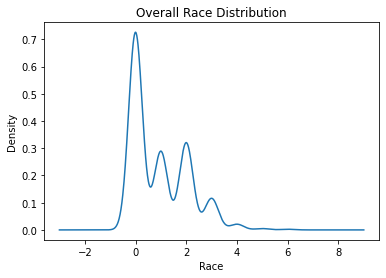

In [60]:
pop_race = df_race_signal['race']
pop_race.plot(kind='density', title='Overall Race Distribution')
plt.xlabel('Race')
print()

----
Plot prediction Lower Decile Range (confidence) distribution

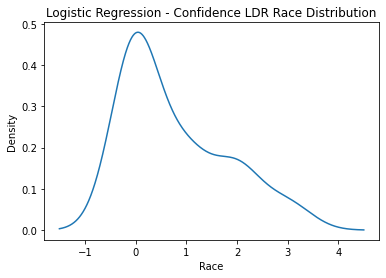

In [87]:
ldr_race = df_pred_logistic_ldr.Race
ldr_race.plot(kind='density', title='Logistic Regression - Confidence LDR Race Distribution')
plt.xlabel('Race')
print()

Shapiro-Wilk Normality Test
----
$H_0$ = the data was drawn from a normal distribution

In [24]:
stats.shapiro(pop_race)

ShapiroResult(statistic=0.7941691875457764, pvalue=1.895033534699303e-36)

In [25]:
stats.shapiro(ldr_race)

ShapiroResult(statistic=0.7528342008590698, pvalue=8.066829764175054e-07)

__Conclusion__:

Both the population-race distribution and the prediction-confidence LDR race distribution fail the Shapiro-Wilk Normality test.

We will have to use a non-parametric test.

In [26]:
stats.variation(pop_race)

1.1765201075964045

In [27]:
stats.variation(ldr_race)

1.2736830337032021

$H_0$ = all input samples are from populations with equal variances

In [32]:
stats.levene(pop_race, ldr_race)

LeveneResult(statistic=2.2678878011041803, pvalue=0.13233490083395943)

We fail to rejected the null hypothesis that samples have equal variance

In [33]:
stats.mannwhitneyu(pop_race, ldr_race)

MannwhitneyuResult(statistic=25812.0, pvalue=0.3813075237168556)

The above test is incorrect, as `Race` is not ordinal
----

In [61]:
# stats.ttest_ind_from_stats?

# Signature:
# stats.ttest_ind_from_stats(
#     mean1,
#     std1,
#     nobs1,
#     mean2,
#     std2,
#     nobs2,
#     equal_var=True,
#     alternative='two-sided',
# )
# Docstring:
# T-test for means of two independent samples from descriptive statistics.

# This is a two-sided test for the null hypothesis that two independent
# samples have identical average (expected) values.

In [47]:
# need std for this test
for i, row in df_logistic_ldr_race_disparity.iterrows():
    print(f'Race = {i}')
    print(stats.ttest_ind_from_stats(mean1=row.prevalence, std1=1, nobs1=row.prevalence_n, 
                                     mean2=row.low_confidence, std2=1, nobs2=row.low_confidence_n))

Race = (0,)
Ttest_indResult(statistic=-0.27247426224527455, pvalue=0.7853497366259188)
Race = (1,)
Ttest_indResult(statistic=-0.01390641685525306, pvalue=0.9889161954169475)
Race = (2,)
Ttest_indResult(statistic=0.10878495128601415, pvalue=0.9134553857414007)
Race = (3,)
Ttest_indResult(statistic=0.005683520519737914, pvalue=0.9954771490907556)
Race = (4,)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Race = (5,)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Race = (6,)
Ttest_indResult(statistic=nan, pvalue=nan)


In [416]:
pred = df[~df.verdict].sort_values(by=['confidence','credibility']).iloc[2,:]
pred

classes                      [1]
confidence              0.921642
credibility             0.100746
verdict                    False
Race                           2
class                          0
class_0                        7
class_1                        6
confidence_ensemble     0.617804
credibility_ensemble    0.662047
Name: 191, dtype: object

In [16]:
import plotly.graph_objects as go

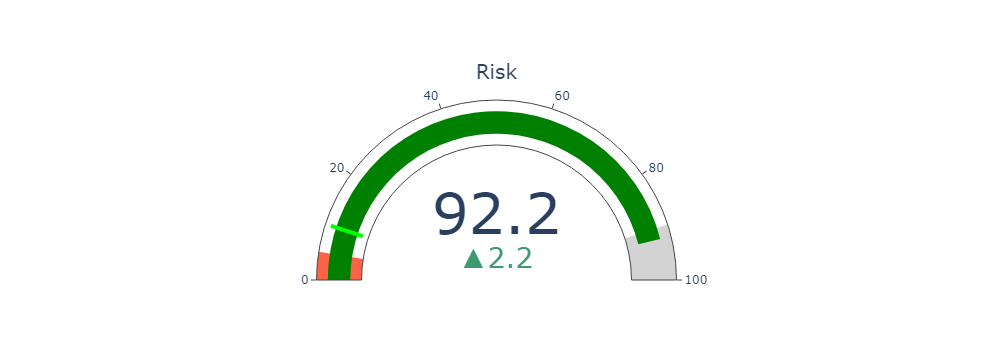

In [454]:
min_cred = 5
min_conf = 90
conf = pred.confidence*100
cred = pred.credibility*100
second_most_cred = (1 - pred.credibility) * 100
cred_threshold_clr = 'red' if cred < min_cred else 'lime'
conf_color = 'red' if conf < min_conf else 'green'

fig =go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=conf,
    mode='gauge+number+delta',
    title={'text':'Risk'},
    delta={'reference':second_most_cred},
    gauge={'axis': {'range': [None,100]},
           'steps': [
               {'range': [0,min_cred], 'color': 'tomato'},
               {'range': [min_conf,100], 'color': 'lightgray'}],
           'threshold': {'line': {'color': cred_threshold_clr, 'width': 4}, 'thickness': 0.75, 'value': cred}}))
fig.show()

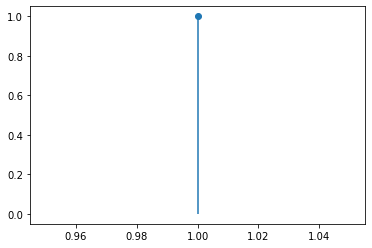

In [171]:
fig,ax = plt.subplots()
plt.stem(1,1)
plt.stem?

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
82,[],0.917910,0.089552,0.1,"[(0.08208955223880597, 0), (0.0895522388059701...",False,0.500000,0,2,0.285714,0.038462,2,3,0
116,[],0.917910,0.097015,0.1,"[(0.09701492537313433, 0), (0.0820895522388059...",False,0.500000,0,2,0.571429,1.000000,0,0,1
191,[1],0.921642,0.100746,0.1,"[(0.07835820895522388, 0), (0.1007462686567164...",False,0.470588,0,2,0.714286,0.051282,1,2,0
85,[1],0.929104,0.108209,0.1,"[(0.0708955223880597, 0), (0.10820895522388059...",False,0.411765,2,0,0.571429,0.089744,0,0,0
287,[1],0.929104,0.108209,0.1,"[(0.0708955223880597, 0), (0.10820895522388059...",False,0.441176,1,1,0.142857,0.064103,0,3,0


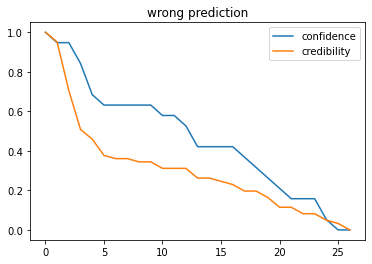

In [164]:
df=tt.loc[0, 'df']
util.plot_conf_cred(df[~df.verdict].sort_values(by=['confidence','credibility']), title='wrong prediction')
df[~df.verdict].sort_values(by=['confidence','credibility']).head()
# df[~df.verdict].sort_values(by=['confidence','credibility'])

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
82,[],0.91791,0.089552,0.1,"[(0.08208955223880597, 0), (0.0895522388059701...",False,0.500000,0,2,0.285714,0.038462,2,3,0
116,[],0.91791,0.097015,0.1,"[(0.09701492537313433, 0), (0.0820895522388059...",False,0.500000,0,2,0.571429,1.000000,0,0,1
94,[0],0.91791,0.100746,0.1,"[(0.10074626865671642, 0), (0.0820895522388059...",True,0.470588,0,2,0.571429,1.000000,0,2,0
134,[1],0.91791,0.100746,0.1,"[(0.08208955223880597, 0), (0.1007462686567164...",True,0.529412,0,2,0.285714,1.000000,0,1,1
286,[0],0.91791,0.100746,0.1,"[(0.10074626865671642, 0), (0.0820895522388059...",True,0.470588,0,2,0.571429,0.051282,1,2,0


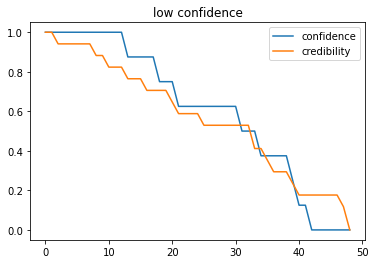

In [165]:
util.plot_conf_cred(df[df.confidence < 0.95].sort_values(by=['confidence','credibility']), title='low confidence')
df[df.confidence < 0.95].sort_values(by=['confidence','credibility']).head()
# df[df.confidence < 0.95].sort_values(by=['confidence','credibility'])

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...
1,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...
2,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...


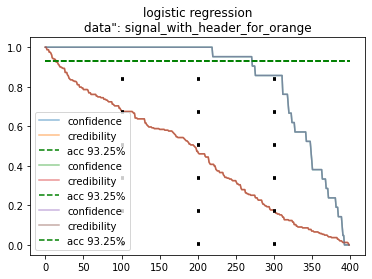

In [128]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(cp.nonconformity.InverseProbability(Orange.classification.LogisticRegressionLearner()))
tt = run_experiments(cc, train, test, calibrate, times=3)

plot_experiments(tt)
tt

Notice LR doesn't change, but RF below does

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.966604,0.633946,0.93,0.0,0.9725,0.9025,0.0275,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...
1,0.959636,0.677509,0.915,0.0,0.9725,0.8875,0.0275,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...
2,0.96472,0.662351,0.9475,0.0,0.895,0.8425,0.105,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...


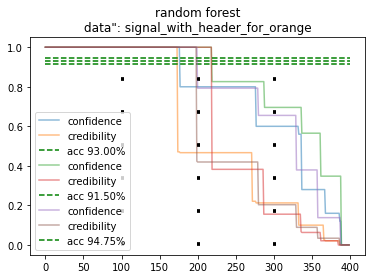

In [127]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(cp.nonconformity.InverseProbability(Orange.classification.RandomForestLearner()))
tt = run_experiments(cc, train, test, calibrate, times=3)

plot_experiments(tt)
tt

-----

-----